# Risk-management


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def cleanse_data(df):
    # Deep copy of original dataframe
    df = df.copy(deep=True)
    
    # Make categorical data types
    for i in ['legal_form', 'type_pl', 'sector']:
        df[i] = df[i].astype('category')
    
    # Handle leading zeros in zip code
    idx = df['zip_code'].apply(lambda x: len(x)) == 4
    df.loc[idx, 'zip_code'] = '0' + df.loc[idx, 'zip_code']
    
    # Replace NaN in PL items with 0
    for i in ['earn_from_op', 'fin_result', 'oth_interest_inc', 'oth_interest_exp', 
              'result_from_ord_bus', 'total_result', 'annual_profit']:
        df[i] = df[i].fillna(0.00)
        
    # Set gross perforamance equal to 1 if missing
    df['gross_performance'] = df['gross_performance'].fillna(df['sales'])
    df['gross_profit'] = df['gross_profit'].fillna((df['gross_profit'] / df['sales']).median() * df['sales'])    
    
    # Return cleansed dataframe
    return df

In [3]:
def load_data_as_dic():
    res = {
        'train': pd.read_csv('Training_Dataset.csv', sep=';', dtype={'zip_code': str}),
        'test': pd.read_csv('Test_Dataset.csv', sep=';', dtype={'zip_code': str}),
    }
    return res
data_dict = load_data_as_dic()

In [4]:
df_train = cleanse_data(data_dict.get('train'))
df_test = cleanse_data(data_dict.get('test'))

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       669 non-null    object  
 1   default                  669 non-null    int64   
 2   legal_form               669 non-null    category
 3   zip_code                 669 non-null    object  
 4   sector                   669 non-null    category
 5   year_inc                 669 non-null    int64   
 6   count_emp                313 non-null    float64 
 7   type_pl                  669 non-null    category
 8   sales                    668 non-null    float64 
 9   gross_performance        668 non-null    float64 
 10  gross_profit             668 non-null    float64 
 11  earn_from_op             669 non-null    float64 
 12  fin_result               669 non-null    float64 
 13  oth_interest_inc         669 non-null    float64 
 14  oth_intere

In [6]:
df_train.columns

Index(['id', 'default', 'legal_form', 'zip_code', 'sector', 'year_inc',
       'count_emp', 'type_pl', 'sales', 'gross_performance', 'gross_profit',
       'earn_from_op', 'fin_result', 'oth_interest_inc', 'oth_interest_exp',
       'result_from_ord_bus', 'total_result', 'annual_profit', 'total_assets',
       'total_liabilities_st', 'total_liabilities_mt', 'total_liabilities_lt',
       'bank_liabilities_st', 'bank_liabilities_mt', 'bank_liabilities_lt',
       'trade_payables_st', 'trade_payables_mt', 'trade_payables_lt',
       'bonds_payables_st', 'bonds_payables_mt', 'bonds_payables_lt',
       'total_equity', 'current_assets', 'monetary_current_assets', 'cash',
       'trade_receivables_st', 'trade_receivables_lt', 'cf_operating',
       'cf_investment', 'cf_financing'],
      dtype='object')

In [7]:
df_train.head()

,id,default,legal_form,zip_code,sector,year_inc,count_emp,type_pl,sales,gross_performance,...,bonds_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,trade_receivables_lt,cf_operating,cf_investment,cf_financing
0,C_120,0,GmbH,13353,87100,1962,323.0,GKV,3.864034e+06,7.597353e+05,...,NaN,5.164048e+04,2.810119e+07,1.111696e+07,9146283.79,617816.28,NaN,9.548544e+06,-7.536444e+06,-22026.07
1,C_173,0,Einzelfirma,12165,47730,1908,NaN,GKV,1.104478e+08,1.104478e+08,...,NaN,4.547445e+08,3.546565e+07,8.545184e+06,5036615.09,516646.73,NaN,1.301809e+08,-1.419776e+08,12567030.80
2,C_740,0,GmbH,14089,69204,1986,NaN,GKV,7.289467e+05,7.289467e+05,...,NaN,NaN,6.419598e+04,2.865919e+04,5598.17,NaN,NaN,5.263264e+04,-5.348700e+02,-54578.91
3,C_931,0,GmbH,10969,68200,1991,2.0,GKV,1.508435e+08,1.479894e+08,...,NaN,6.657375e+08,8.479909e+07,3.142807e+07,11542490.91,326731.07,8000.0,4.007555e+07,-8.337054e+06,-34594274.52
4,C_343,0,GmbH,16792,78100,1991,NaN,GKV,2.843420e+08,2.843420e+08,...,NaN,2.883814e+09,4.229090e+08,4.312550e+08,21696000.00,448000.00,NaN,5.861770e+08,-7.339750e+08,-95826000.00


In [8]:
df_test.columns

Index(['id', 'legal_form', 'zip_code', 'sector', 'year_inc', 'count_emp',
       'type_pl', 'sales', 'gross_performance', 'gross_profit', 'earn_from_op',
       'fin_result', 'oth_interest_inc', 'oth_interest_exp',
       'result_from_ord_bus', 'total_result', 'annual_profit', 'total_assets',
       'total_liabilities_st', 'total_liabilities_mt', 'total_liabilities_lt',
       'bank_liabilities_st', 'bank_liabilities_mt', 'bank_liabilities_lt',
       'trade_payables_st', 'trade_payables_mt', 'trade_payables_lt',
       'bonds_payables_st', 'bonds_payables_mt', 'bonds_payables_lt',
       'total_equity', 'current_assets', 'monetary_current_assets', 'cash',
       'trade_receivables_st', 'trade_receivables_lt', 'cf_operating',
       'cf_investment', 'cf_financing'],
      dtype='object')

In [9]:
df_train.head()

,id,default,legal_form,zip_code,sector,year_inc,count_emp,type_pl,sales,gross_performance,...,bonds_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,trade_receivables_lt,cf_operating,cf_investment,cf_financing
0,C_120,0,GmbH,13353,87100,1962,323.0,GKV,3.864034e+06,7.597353e+05,...,NaN,5.164048e+04,2.810119e+07,1.111696e+07,9146283.79,617816.28,NaN,9.548544e+06,-7.536444e+06,-22026.07
1,C_173,0,Einzelfirma,12165,47730,1908,NaN,GKV,1.104478e+08,1.104478e+08,...,NaN,4.547445e+08,3.546565e+07,8.545184e+06,5036615.09,516646.73,NaN,1.301809e+08,-1.419776e+08,12567030.80
2,C_740,0,GmbH,14089,69204,1986,NaN,GKV,7.289467e+05,7.289467e+05,...,NaN,NaN,6.419598e+04,2.865919e+04,5598.17,NaN,NaN,5.263264e+04,-5.348700e+02,-54578.91
3,C_931,0,GmbH,10969,68200,1991,2.0,GKV,1.508435e+08,1.479894e+08,...,NaN,6.657375e+08,8.479909e+07,3.142807e+07,11542490.91,326731.07,8000.0,4.007555e+07,-8.337054e+06,-34594274.52
4,C_343,0,GmbH,16792,78100,1991,NaN,GKV,2.843420e+08,2.843420e+08,...,NaN,2.883814e+09,4.229090e+08,4.312550e+08,21696000.00,448000.00,NaN,5.861770e+08,-7.339750e+08,-95826000.00


In [10]:
df_train.default.value_counts()

0    631
1     38
Name: default, dtype: int64

In [11]:
df_test = cleanse_data(data_dict.get('test'))

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       330 non-null    object  
 1   legal_form               330 non-null    category
 2   zip_code                 330 non-null    object  
 3   sector                   330 non-null    category
 4   year_inc                 330 non-null    int64   
 5   count_emp                154 non-null    float64 
 6   type_pl                  330 non-null    category
 7   sales                    330 non-null    float64 
 8   gross_performance        330 non-null    float64 
 9   gross_profit             330 non-null    float64 
 10  earn_from_op             330 non-null    float64 
 11  fin_result               330 non-null    float64 
 12  oth_interest_inc         330 non-null    float64 
 13  oth_interest_exp         330 non-null    float64 
 14  result_fro

In [13]:
df_train.head(8)

,id,default,legal_form,zip_code,sector,year_inc,count_emp,type_pl,sales,gross_performance,...,bonds_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,trade_receivables_lt,cf_operating,cf_investment,cf_financing
0,C_120,0,GmbH,13353,87100,1962,323.0,GKV,3.864034e+06,7.597353e+05,...,NaN,5.164048e+04,2.810119e+07,1.111696e+07,9146283.79,617816.28,NaN,9.548544e+06,-7.536444e+06,-22026.07
1,C_173,0,Einzelfirma,12165,47730,1908,NaN,GKV,1.104478e+08,1.104478e+08,...,NaN,4.547445e+08,3.546565e+07,8.545184e+06,5036615.09,516646.73,NaN,1.301809e+08,-1.419776e+08,12567030.80
2,C_740,0,GmbH,14089,69204,1986,NaN,GKV,7.289467e+05,7.289467e+05,...,NaN,NaN,6.419598e+04,2.865919e+04,5598.17,NaN,NaN,5.263264e+04,-5.348700e+02,-54578.91
3,C_931,0,GmbH,10969,68200,1991,2.0,GKV,1.508435e+08,1.479894e+08,...,NaN,6.657375e+08,8.479909e+07,3.142807e+07,11542490.91,326731.07,8000.0,4.007555e+07,-8.337054e+06,-34594274.52
4,C_343,0,GmbH,16792,78100,1991,NaN,GKV,2.843420e+08,2.843420e+08,...,NaN,2.883814e+09,4.229090e+08,4.312550e+08,21696000.00,448000.00,NaN,5.861770e+08,-7.339750e+08,-95826000.00
5,C_590,0,GmbH,13125,86101,1991,283.0,GKV,9.811591e+06,9.681040e+06,...,NaN,2.032968e+07,7.366730e+06,5.421665e+06,322573.88,372298.68,NaN,4.369386e+05,-1.879056e+06,-13729379.17
6,C_206,0,GmbH,14059,86101,1993,505.0,GKV,2.602532e+07,2.601554e+07,...,NaN,1.373367e+07,1.450475e+07,3.441491e+06,322075.13,3034766.29,NaN,2.862350e+06,-6.673425e+05,-2091455.69
7,C_248,0,GmbH,12681,71122,1999,NaN,GKV,1.384595e+05,1.384595e+05,...,NaN,1.552805e+06,4.966969e+05,4.500943e+04,35726.57,NaN,NaN,1.947540e+05,3.318306e+05,-798859.83


# Dataset Preparation


In [14]:
df_train.describe()

,default,year_inc,count_emp,sales,gross_performance,gross_profit,earn_from_op,fin_result,oth_interest_inc,oth_interest_exp,...,bonds_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,trade_receivables_lt,cf_operating,cf_investment,cf_financing
count,669.000000,669.000000,313.000000,6.680000e+02,6.680000e+02,6.680000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,...,0.0,6.490000e+02,6.680000e+02,6.690000e+02,6.360000e+02,3.380000e+02,2.200000e+01,6.670000e+02,6.670000e+02,6.670000e+02
mean,0.056801,1981.225710,284.028754,9.699918e+07,9.716163e+07,2.176481e+07,2.723845e+06,1.277131e+06,1.324854e+05,7.311423e+05,...,NaN,2.089271e+07,2.206604e+07,1.398691e+07,2.728314e+06,6.961090e+06,2.933409e+06,6.415765e+06,-4.328842e+06,-2.238772e+06
std,0.231636,113.574522,1096.368307,1.390957e+09,1.390970e+09,9.301932e+07,3.852800e+07,3.363094e+07,9.987101e+05,3.619410e+06,...,NaN,1.335176e+08,1.089597e+08,8.866408e+07,1.288107e+07,3.947975e+07,1.285869e+07,6.849934e+07,3.871231e+07,7.151422e+07
min,0.000000,0.000000,1.000000,4.856800e+02,4.856800e+02,-8.197000e+06,-1.340470e+08,-2.087933e+08,0.000000e+00,0.000000e+00,...,NaN,-2.440000e-09,2.733000e+02,0.000000e+00,3.090000e+00,2.461000e+01,1.030900e+02,-1.598027e+08,-7.339750e+08,-1.775700e+09
25%,0.000000,1985.000000,29.000000,1.036589e+06,1.046823e+06,5.931472e+05,2.162970e+04,-1.466459e+05,3.658000e+01,4.450000e+03,...,NaN,1.016875e+05,3.048914e+05,1.731555e+05,1.595936e+04,1.214250e+05,1.876473e+03,3.375540e+03,-6.171353e+05,-2.987550e+05
50%,0.000000,1996.000000,91.000000,4.544488e+06,4.705269e+06,2.355424e+06,1.540245e+05,-1.451936e+04,1.623710e+03,3.164396e+04,...,NaN,6.960752e+05,1.781164e+06,8.359785e+05,1.521253e+05,5.356728e+05,2.718468e+04,1.502464e+05,-6.404797e+04,-1.017058e+04
75%,0.000000,2004.000000,236.000000,2.691905e+07,2.743193e+07,1.138728e+07,9.173175e+05,-1.052000e+01,2.139472e+04,2.487613e+05,...,NaN,5.868261e+06,1.088687e+07,5.599258e+06,1.133032e+06,3.077810e+06,1.966000e+05,1.359628e+06,-3.717055e+03,5.029357e+04
max,1.000000,2011.000000,17661.000000,3.577930e+10,3.577930e+10,1.253677e+09,9.684000e+08,8.108910e+08,1.982832e+07,6.048314e+07,...,NaN,2.883814e+09,2.140600e+09,1.951300e+09,2.562816e+08,6.559000e+08,6.047698e+07,1.601200e+09,1.378791e+08,3.915457e+08


In [15]:
df_train.columns

Index(['id', 'default', 'legal_form', 'zip_code', 'sector', 'year_inc',
       'count_emp', 'type_pl', 'sales', 'gross_performance', 'gross_profit',
       'earn_from_op', 'fin_result', 'oth_interest_inc', 'oth_interest_exp',
       'result_from_ord_bus', 'total_result', 'annual_profit', 'total_assets',
       'total_liabilities_st', 'total_liabilities_mt', 'total_liabilities_lt',
       'bank_liabilities_st', 'bank_liabilities_mt', 'bank_liabilities_lt',
       'trade_payables_st', 'trade_payables_mt', 'trade_payables_lt',
       'bonds_payables_st', 'bonds_payables_mt', 'bonds_payables_lt',
       'total_equity', 'current_assets', 'monetary_current_assets', 'cash',
       'trade_receivables_st', 'trade_receivables_lt', 'cf_operating',
       'cf_investment', 'cf_financing'],
      dtype='object')

In [16]:
df_train.default.value_counts()

0    631
1     38
Name: default, dtype: int64

## Using a data profiling tool

In [17]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """ Converts the data types of the variables in a dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe
        
    Returns:
        pd.DataFrame: The dataframe with converted data types.
    """
    df_copy = df.copy()
    for i in df_copy.columns:
        if (df_copy[i].dtype == 'O') & (df_copy[i].nunique() > 2):
            df_copy[i] = df_copy[i].astype('category')
        elif (df_copy[i].dtype == 'O') & (df_copy[i].nunique() <= 2):
            df_copy[i] = df_copy[i] == 'Yes'
        elif (df_copy[i].dtype == 'int64') & (df[i].unique().tolist() == [0, 1]):
            df_copy[i] = df_copy[i].astype('bool')
        else:
            pass
    return df_copy

In [18]:
df_train = convert_data_types(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       669 non-null    category
 1   default                  669 non-null    bool    
 2   legal_form               669 non-null    category
 3   zip_code                 669 non-null    category
 4   sector                   669 non-null    category
 5   year_inc                 669 non-null    int64   
 6   count_emp                313 non-null    float64 
 7   type_pl                  669 non-null    category
 8   sales                    668 non-null    float64 
 9   gross_performance        668 non-null    float64 
 10  gross_profit             668 non-null    float64 
 11  earn_from_op             669 non-null    float64 
 12  fin_result               669 non-null    float64 
 13  oth_interest_inc         669 non-null    float64 
 14  oth_intere

In [19]:
df_train.shape

(669, 40)

In [20]:
# Count missing values in each column
missing_values = df_train.isnull().sum()
missing_values

id                           0
default                      0
legal_form                   0
zip_code                     0
sector                       0
year_inc                     0
count_emp                  356
type_pl                      0
sales                        1
gross_performance            1
gross_profit                 1
earn_from_op                 0
fin_result                   0
oth_interest_inc             0
oth_interest_exp             0
result_from_ord_bus          0
total_result                 0
annual_profit                0
total_assets                 1
total_liabilities_st         0
total_liabilities_mt         0
total_liabilities_lt         0
bank_liabilities_st        343
bank_liabilities_mt        476
bank_liabilities_lt        531
trade_payables_st          135
trade_payables_mt          646
trade_payables_lt          666
bonds_payables_st          669
bonds_payables_mt          664
bonds_payables_lt          669
total_equity                20
current_

In [21]:
columns_to_drop = ['bank_liabilities_mt', 'bank_liabilities_lt', 'trade_payables_mt', 'bonds_payables_st', 'bonds_payables_mt', 'bonds_payables_lt', 'trade_receivables_lt']

df_train.drop(columns=columns_to_drop, inplace=True)


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       669 non-null    category
 1   default                  669 non-null    bool    
 2   legal_form               669 non-null    category
 3   zip_code                 669 non-null    category
 4   sector                   669 non-null    category
 5   year_inc                 669 non-null    int64   
 6   count_emp                313 non-null    float64 
 7   type_pl                  669 non-null    category
 8   sales                    668 non-null    float64 
 9   gross_performance        668 non-null    float64 
 10  gross_profit             668 non-null    float64 
 11  earn_from_op             669 non-null    float64 
 12  fin_result               669 non-null    float64 
 13  oth_interest_inc         669 non-null    float64 
 14  oth_intere

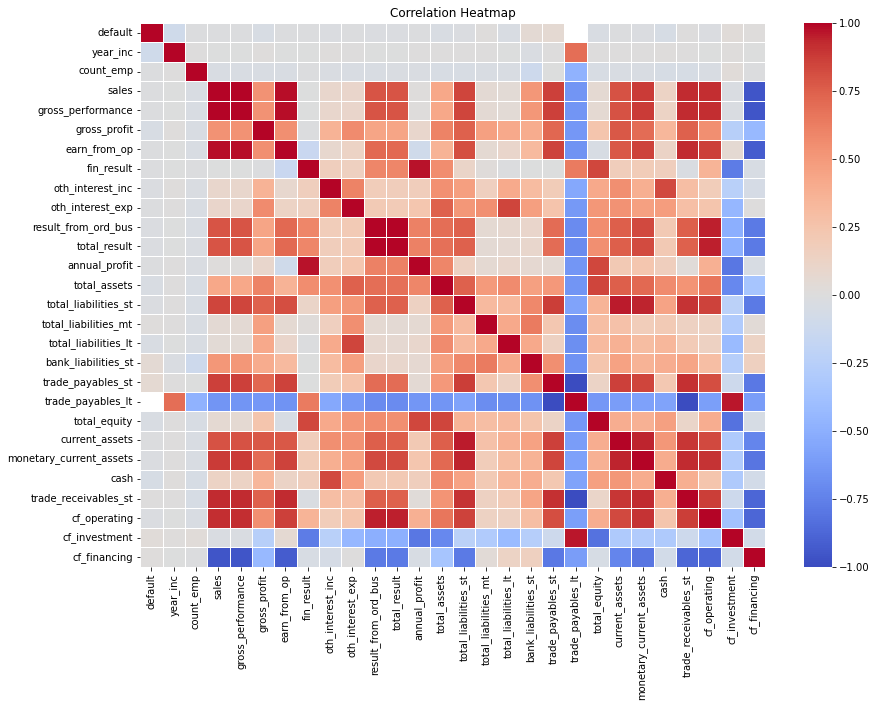

In [23]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
correlation_matrix

,default,year_inc,count_emp,sales,gross_performance,gross_profit,earn_from_op,fin_result,oth_interest_inc,oth_interest_exp,...,trade_payables_st,trade_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,cf_operating,cf_investment,cf_financing
default,1.000000,-0.095004,-0.010045,-0.011852,-0.011732,-0.041317,-0.012218,-0.012863,-0.021459,-0.011651,...,0.056578,NaN,-0.033360,-0.011042,-0.017198,-0.048689,0.005427,-0.023116,0.025360,0.008543
year_inc,-0.095004,1.000000,0.000475,-0.001505,-0.001495,0.012066,-0.003591,-0.000044,0.008887,0.002224,...,0.002970,0.690448,0.003390,0.005723,0.004319,0.007970,0.001380,-0.005278,0.011964,-0.001666
count_emp,-0.010045,0.000475,1.000000,-0.032532,-0.032637,-0.034854,-0.036063,-0.009731,-0.029083,-0.033321,...,-0.002280,-0.480098,-0.042107,-0.038813,-0.038924,-0.051127,-0.052133,-0.033134,0.024778,-0.010674
sales,-0.011852,-0.001505,-0.032532,1.000000,0.999999,0.538790,0.976853,-0.000002,0.086074,0.099520,...,0.866394,-0.650327,0.059191,0.804032,0.877764,0.131300,0.924142,0.915320,-0.028010,-0.957099
gross_performance,-0.011732,-0.001495,-0.032637,0.999999,1.000000,0.538883,0.976845,-0.000017,0.086222,0.099679,...,0.866483,-0.650750,0.059205,0.804130,0.877832,0.131336,0.924133,0.915304,-0.028044,-0.957068
gross_profit,-0.041317,0.012066,-0.034854,0.538790,0.538883,1.000000,0.552396,-0.008833,0.362646,0.568927,...,0.718911,-0.634814,0.249432,0.776992,0.700093,0.337302,0.746638,0.550923,-0.252774,-0.433507
earn_from_op,-0.012218,-0.003591,-0.036063,0.976853,0.976845,0.552396,1.000000,-0.143665,0.079004,0.126365,...,0.852595,-0.658762,-0.045200,0.780651,0.853517,0.121362,0.926843,0.860502,0.061465,-0.929594
fin_result,-0.012863,-0.000044,-0.009731,-0.000002,-0.000017,-0.008833,-0.143665,1.000000,0.167789,0.151668,...,-0.002914,0.635284,0.836150,0.172795,0.192126,0.168760,-0.027651,0.352524,-0.774796,-0.044504
oth_interest_inc,-0.021459,0.008887,-0.029083,0.086074,0.086222,0.362646,0.079004,0.167789,1.000000,0.603740,...,0.187953,-0.542099,0.416477,0.552338,0.387993,0.830975,0.296548,0.187071,-0.245875,-0.060361
oth_interest_exp,-0.011651,0.002224,-0.033321,0.099520,0.099679,0.568927,0.126365,0.151668,0.603740,1.000000,...,0.256686,-0.626368,0.513881,0.533979,0.464406,0.477968,0.287132,0.242751,-0.451863,0.006516


In [25]:
# Count missing values in each column
missing_values = df_train.isnull().sum()
print(missing_values)

id                           0
default                      0
legal_form                   0
zip_code                     0
sector                       0
year_inc                     0
count_emp                  356
type_pl                      0
sales                        1
gross_performance            1
gross_profit                 1
earn_from_op                 0
fin_result                   0
oth_interest_inc             0
oth_interest_exp             0
result_from_ord_bus          0
total_result                 0
annual_profit                0
total_assets                 1
total_liabilities_st         0
total_liabilities_mt         0
total_liabilities_lt         0
bank_liabilities_st        343
trade_payables_st          135
trade_payables_lt          666
total_equity                20
current_assets               1
monetary_current_assets      0
cash                        33
trade_receivables_st       331
cf_operating                 2
cf_investment                2
cf_finan

In [26]:
df_train.describe()

,year_inc,count_emp,sales,gross_performance,gross_profit,earn_from_op,fin_result,oth_interest_inc,oth_interest_exp,result_from_ord_bus,...,trade_payables_st,trade_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,cf_operating,cf_investment,cf_financing
count,669.000000,313.000000,6.680000e+02,6.680000e+02,6.680000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,6.690000e+02,...,5.340000e+02,3.000000e+00,6.490000e+02,6.680000e+02,6.690000e+02,6.360000e+02,3.380000e+02,6.670000e+02,6.670000e+02,6.670000e+02
mean,1981.225710,284.028754,9.699918e+07,9.716163e+07,2.176481e+07,2.723845e+06,1.277131e+06,1.324854e+05,7.311423e+05,4.000976e+06,...,3.785995e+06,6.764804e+05,2.089271e+07,2.206604e+07,1.398691e+07,2.728314e+06,6.961090e+06,6.415765e+06,-4.328842e+06,-2.238772e+06
std,113.574522,1096.368307,1.390957e+09,1.390970e+09,9.301932e+07,3.852800e+07,3.363094e+07,9.987101e+05,3.619410e+06,4.736185e+07,...,2.382013e+07,1.068559e+06,1.335176e+08,1.089597e+08,8.866408e+07,1.288107e+07,3.947975e+07,6.849934e+07,3.871231e+07,7.151422e+07
min,0.000000,1.000000,4.856800e+02,4.856800e+02,-8.197000e+06,-1.340470e+08,-2.087933e+08,0.000000e+00,0.000000e+00,-2.130173e+08,...,8.739000e+01,1.600000e+04,-2.440000e-09,2.733000e+02,0.000000e+00,3.090000e+00,2.461000e+01,-1.598027e+08,-7.339750e+08,-1.775700e+09
25%,1985.000000,29.000000,1.036589e+06,1.046823e+06,5.931472e+05,2.162970e+04,-1.466459e+05,3.658000e+01,4.450000e+03,1.597170e+04,...,5.170442e+04,6.007254e+04,1.016875e+05,3.048914e+05,1.731555e+05,1.595936e+04,1.214250e+05,3.375540e+03,-6.171353e+05,-2.987550e+05
50%,1996.000000,91.000000,4.544488e+06,4.705269e+06,2.355424e+06,1.540245e+05,-1.451936e+04,1.623710e+03,3.164396e+04,1.302463e+05,...,2.341269e+05,1.041451e+05,6.960752e+05,1.781164e+06,8.359785e+05,1.521253e+05,5.356728e+05,1.502464e+05,-6.404797e+04,-1.017058e+04
75%,2004.000000,236.000000,2.691905e+07,2.743193e+07,1.138728e+07,9.173175e+05,-1.052000e+01,2.139472e+04,2.487613e+05,8.492299e+05,...,1.502772e+06,1.006721e+06,5.868261e+06,1.088687e+07,5.599258e+06,1.133032e+06,3.077810e+06,1.359628e+06,-3.717055e+03,5.029357e+04
max,2011.000000,17661.000000,3.577930e+10,3.577930e+10,1.253677e+09,9.684000e+08,8.108910e+08,1.982832e+07,6.048314e+07,9.652000e+08,...,4.556000e+08,1.909296e+06,2.883814e+09,2.140600e+09,1.951300e+09,2.562816e+08,6.559000e+08,1.601200e+09,1.378791e+08,3.915457e+08


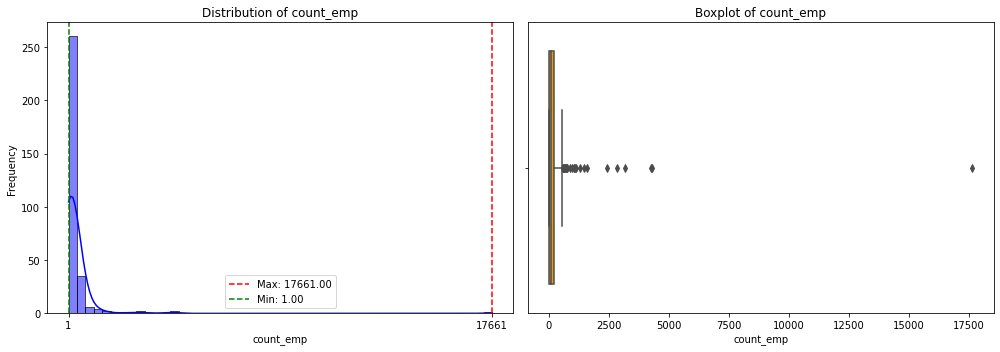

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution_with_extremes_and_boxplot(dataframe, column_name):
    """
    Plot the distribution of a column in a DataFrame using seaborn.
    Highlight the maximum and minimum values with xticks and yticks.
    Additionally, include a boxplot.

    Parameters:
    - dataframe: pandas DataFrame
    - column_name: str, the name of the column to plot
    """
    # Find maximum and minimum values
    max_value = dataframe[column_name].max()
    min_value = dataframe[column_name].min()

    # Plot distribution
    plt.figure(figsize=(14, 5))

    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(dataframe[column_name], kde=True, color='blue', bins=50)
    plt.axvline(x=max_value, color='red', linestyle='--', label=f'Max: {max_value:.2f}')
    plt.axvline(x=min_value, color='green', linestyle='--', label=f'Min: {min_value:.2f}')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.xticks([min_value, max_value])
    plt.legend()

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dataframe[column_name], color='orange')
    plt.title(f'Boxplot of {column_name}')
    plt.xlabel(column_name)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'your_column_name' with the actual column name you want to plot
plot_distribution_with_extremes_and_boxplot(df_train, 'count_emp')


In [28]:
df_train.count_emp.value_counts()

2.0      8
3.0      6
64.0     5
11.0     5
4.0      5
        ..
404.0    1
272.0    1
10.0     1
104.0    1
433.0    1
Name: count_emp, Length: 208, dtype: int64

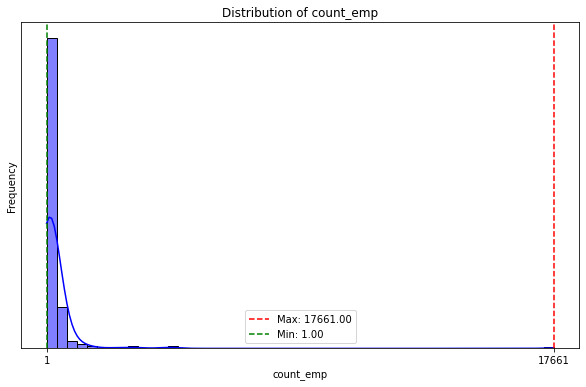

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution_with_extremes(dataframe, column_name):
    """
    Plot the distribution of a column in a DataFrame using seaborn.
    Highlight the maximum and minimum values with xticks and yticks.

    Parameters:
    - dataframe: pandas DataFrame
    - column_name: str, the name of the column to plot
    """
    # Find maximum and minimum values
    max_value = dataframe[column_name].max()
    min_value = dataframe[column_name].min()

    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(dataframe[column_name], kde=True, color='blue', bins=50)
    
    # Highlight maximum and minimum values with xticks and yticks
    plt.axvline(x=max_value, color='red', linestyle='--', label=f'Max: {max_value:.2f}')
    plt.axvline(x=min_value, color='green', linestyle='--', label=f'Min: {min_value:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    
    # Set xticks and yticks
    plt.xticks([min_value, max_value])
    plt.yticks([])  # No yticks for frequency on the right side
    
    plt.legend()
    plt.show()

# Example usage:
# Replace 'your_column_name' with the actual column name you want to plot
plot_distribution_with_extremes(df_train, 'count_emp')


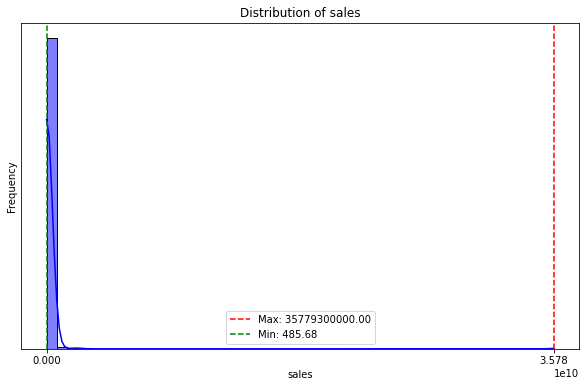

In [30]:
plot_distribution_with_extremes(df_train, 'sales')

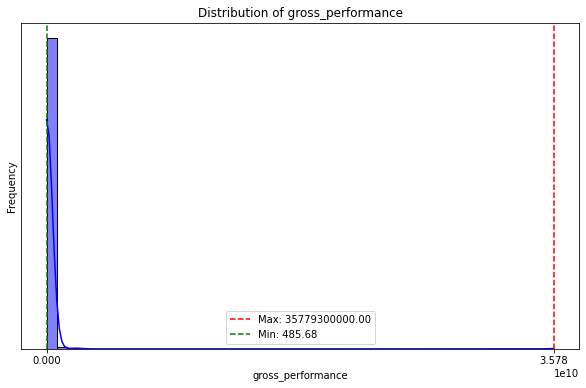

In [31]:
plot_distribution_with_extremes(df_train, 'gross_performance')

In [32]:
for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        # For numeric columns, use mean
        mean_value = df_train[column].mean()
        df_train[column] = df_train[column].fillna(mean_value)
    else:
        # For categorical columns, use mode
        mode_value = df_train[column].mode()[0]
        df_train[column] = df_train[column].fillna(mode_value)



In [33]:
missing_values = df_train.isnull().sum()
print(missing_values)

id                         0
default                    0
legal_form                 0
zip_code                   0
sector                     0
year_inc                   0
count_emp                  0
type_pl                    0
sales                      0
gross_performance          0
gross_profit               0
earn_from_op               0
fin_result                 0
oth_interest_inc           0
oth_interest_exp           0
result_from_ord_bus        0
total_result               0
annual_profit              0
total_assets               0
total_liabilities_st       0
total_liabilities_mt       0
total_liabilities_lt       0
bank_liabilities_st        0
trade_payables_st          0
trade_payables_lt          0
total_equity               0
current_assets             0
monetary_current_assets    0
cash                       0
trade_receivables_st       0
cf_operating               0
cf_investment              0
cf_financing               0
dtype: int64


In [34]:
df_train

,id,default,legal_form,zip_code,sector,year_inc,count_emp,type_pl,sales,gross_performance,...,trade_payables_st,trade_payables_lt,total_equity,current_assets,monetary_current_assets,cash,trade_receivables_st,cf_operating,cf_investment,cf_financing
0,C_120,False,GmbH,13353,87100,1962,323.000000,GKV,3.864034e+06,7.597353e+05,...,5.348013e+06,676480.366667,5.164048e+04,2.810119e+07,1.111696e+07,9146283.79,6.178163e+05,9.548544e+06,-7.536444e+06,-22026.07
1,C_173,False,Einzelfirma,12165,47730,1908,284.028754,GKV,1.104478e+08,1.104478e+08,...,1.396801e+07,676480.366667,4.547445e+08,3.546565e+07,8.545184e+06,5036615.09,5.166467e+05,1.301809e+08,-1.419776e+08,12567030.80
2,C_740,False,GmbH,14089,69204,1986,284.028754,GKV,7.289467e+05,7.289467e+05,...,5.092441e+04,676480.366667,2.089271e+07,6.419598e+04,2.865919e+04,5598.17,6.961090e+06,5.263264e+04,-5.348700e+02,-54578.91
3,C_931,False,GmbH,10969,68200,1991,2.000000,GKV,1.508435e+08,1.479894e+08,...,2.949597e+06,676480.366667,6.657375e+08,8.479909e+07,3.142807e+07,11542490.91,3.267311e+05,4.007555e+07,-8.337054e+06,-34594274.52
4,C_343,False,GmbH,16792,78100,1991,284.028754,GKV,2.843420e+08,2.843420e+08,...,6.790000e+06,676480.366667,2.883814e+09,4.229090e+08,4.312550e+08,21696000.00,4.480000e+05,5.861770e+08,-7.339750e+08,-95826000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,C_117,False,GmbH,82438,46495,1997,284.028754,GKV,2.092688e+07,2.092688e+07,...,3.785995e+06,676480.366667,2.959498e+06,4.896663e+06,1.915337e+06,677789.32,6.961090e+06,5.451731e+05,-2.435268e+05,-537026.92
665,C_755,False,GmbH & Co. KG,82031,68100,2000,284.028754,GKV,5.089641e+06,5.033756e+06,...,4.173312e+04,676480.366667,6.532284e+06,5.290890e+06,3.203740e+06,903999.86,1.403116e+05,8.024164e+05,-5.104500e+04,-156253.86
666,C_875,False,GmbH & Co. KG,82031,68320,2007,284.028754,GKV,1.843728e+05,1.843728e+05,...,3.785995e+06,676480.366667,-1.460000e-11,7.050791e+04,5.519125e+04,5652.17,6.961090e+06,2.530806e+04,-2.630540e+03,-9788.00
667,C_113,False,GmbH,85716,79110,2011,284.028754,GKV,2.614807e+07,2.580716e+07,...,3.785995e+06,676480.366667,3.508818e+06,1.600666e+07,1.014975e+07,3653350.01,4.400972e+06,1.114405e+05,-7.893092e+05,-544300.00


In [35]:
df_train.type_pl.value_counts()

GKV    663
UKV      6
Name: type_pl, dtype: int64

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       669 non-null    category
 1   default                  669 non-null    bool    
 2   legal_form               669 non-null    category
 3   zip_code                 669 non-null    category
 4   sector                   669 non-null    category
 5   year_inc                 669 non-null    int64   
 6   count_emp                669 non-null    float64 
 7   type_pl                  669 non-null    category
 8   sales                    669 non-null    float64 
 9   gross_performance        669 non-null    float64 
 10  gross_profit             669 non-null    float64 
 11  earn_from_op             669 non-null    float64 
 12  fin_result               669 non-null    float64 
 13  oth_interest_inc         669 non-null    float64 
 14  oth_intere

In [37]:
df_train['zip_code'] = df_train['zip_code'].astype('int')
df_train['sector'] = df_train['sector'].astype('int')

In [38]:
columns_to_encode = ['legal_form', 'type_pl']
df_encoded = pd.get_dummies(df_train, columns=columns_to_encode)

In [39]:
df_encoded

,id,default,zip_code,sector,year_inc,count_emp,sales,gross_performance,gross_profit,earn_from_op,...,legal_form_Einzelfirma,legal_form_Freiberufler,legal_form_Genossenschaft,legal_form_GmbH,legal_form_GmbH & Co. KG,legal_form_KG,legal_form_OHG,legal_form_Sonst. Gewerbetreibende,type_pl_GKV,type_pl_UKV
0,C_120,False,13353,87100,1962,323.000000,3.864034e+06,7.597353e+05,1.500839e+07,8.979980e+04,...,0,0,0,1,0,0,0,0,1,0
1,C_173,False,12165,47730,1908,284.028754,1.104478e+08,1.104478e+08,1.254550e+08,5.403381e+07,...,1,0,0,0,0,0,0,0,1,0
2,C_740,False,14089,69204,1986,284.028754,7.289467e+05,7.289467e+05,2.097214e+05,4.539050e+04,...,0,0,0,1,0,0,0,0,1,0
3,C_931,False,10969,68200,1991,2.000000,1.508435e+08,1.479894e+08,1.076359e+08,4.729300e+07,...,0,0,0,1,0,0,0,0,1,0
4,C_343,False,16792,78100,1991,284.028754,2.843420e+08,2.843420e+08,4.233500e+07,-1.340470e+08,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,C_117,False,82438,46495,1997,284.028754,2.092688e+07,2.092688e+07,5.232887e+06,9.173175e+05,...,0,0,0,1,0,0,0,0,1,0
665,C_755,False,82031,68100,2000,284.028754,5.089641e+06,5.033756e+06,1.388887e+06,-9.544115e+04,...,0,0,0,0,1,0,0,0,1,0
666,C_875,False,82031,68320,2007,284.028754,1.843728e+05,1.843728e+05,1.934094e+05,9.855870e+03,...,0,0,0,0,1,0,0,0,1,0
667,C_113,False,85716,79110,2011,284.028754,2.614807e+07,2.580716e+07,1.495712e+07,1.806634e+06,...,0,0,0,1,0,0,0,0,1,0


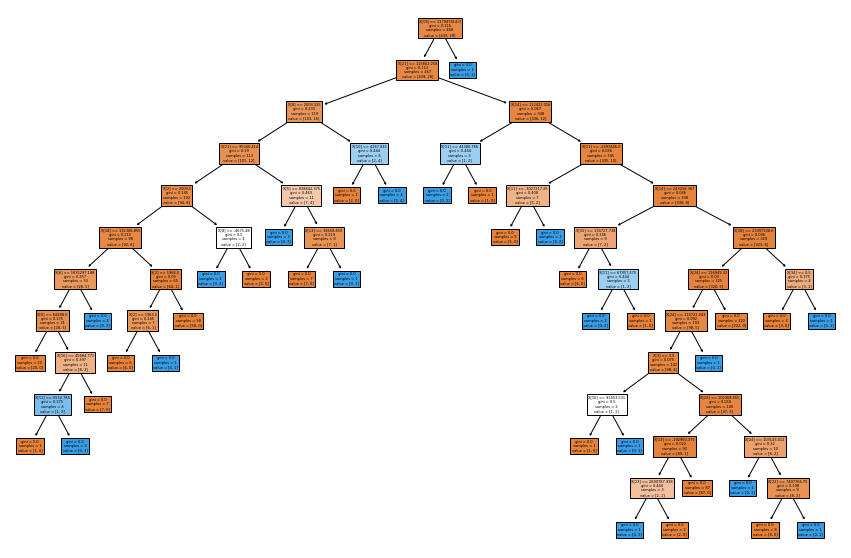

In [49]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Visualize the Decision Tree
plt.figure(figsize=(15,10))
plot_tree(clf, filled=True)
plt.show()


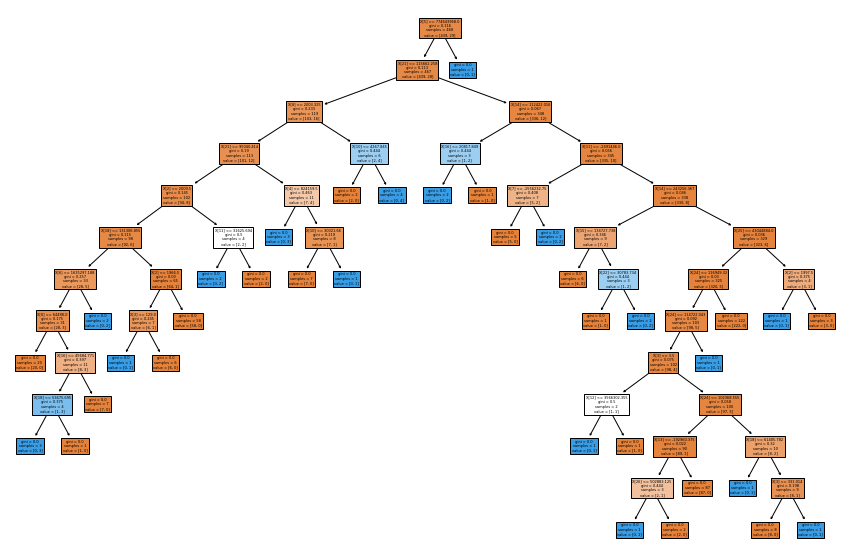

In [50]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Visualize the Decision Tree
plt.figure(figsize=(15,10))
plot_tree(clf, filled=True)
plt.show()


In [51]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier, export_text

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X, y)

# Visualize the Decision Tree in text format
r = export_text(clf, feature_names=list(X.columns))
print(r)


|--- cf_operating <= 326955.64
|   |--- total_liabilities_mt <= 10794633.50
|   |   |--- cash <= 7767.23
|   |   |   |--- cf_operating <= 236730.24
|   |   |   |   |--- year_inc <= 1999.50
|   |   |   |   |   |--- cash <= 1161.03
|   |   |   |   |   |   |--- cf_investment <= -227810.44
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- cf_investment >  -227810.44
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- cash >  1161.03
|   |   |   |   |   |   |--- current_assets <= 30827.36
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- current_assets >  30827.36
|   |   |   |   |   |   |   |--- current_assets <= 56893.56
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- current_assets >  56893.56
|   |   |   |   |   |   |   |   |--- cf_investment <= -38157.46
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- cf_investment >  -38157.46
|   |   |   |  

In [52]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Create RepeatedStratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)

# Evaluate model
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Accuracy: 0.884 (0.034)


In [54]:
# Import necessary libraries
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
import pandas as pd

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Create RepeatedStratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=18, n_repeats=50, random_state=1)

# Define scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Perform cross-validation and store results
cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring)

# Convert results to DataFrame
df_cv_results = pd.DataFrame(cv_results)

# Print DataFrame
print(df_cv_results)


     fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.016685    0.002844       0.868421        0.000000          0.0
1    0.012640    0.002734       0.842105        0.000000          0.0
2    0.013408    0.002747       0.815789        0.000000          0.0
3    0.012030    0.002715       0.918919        0.333333          0.5
4    0.013447    0.002711       0.837838        0.000000          0.0
..        ...         ...            ...             ...          ...
895  0.014350    0.002819       0.837838        0.000000          0.0
896  0.013369    0.002703       0.972973        1.000000          0.5
897  0.015097    0.002704       0.918919        0.000000          0.0
898  0.013555    0.002587       0.972973        1.000000          0.5
899  0.012602    0.002777       0.891892        0.000000          0.0

[900 rows x 5 columns]


In [55]:
# Import necessary libraries
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
import pandas as pd

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Create Decision Tree Classifier
clf = DecisionTreeClassifier()

# Create RepeatedStratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)

# Define scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Perform cross-validation and store results
cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring)

# Convert results to DataFrame
df_cv_results = pd.DataFrame(cv_results)

# Print DataFrame
print(df_cv_results)


     fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.013679    0.003031       0.865672        0.000000         0.00
1    0.011854    0.002790       0.910448        0.250000         0.25
2    0.012571    0.002820       0.880597        0.000000         0.00
3    0.014616    0.002641       0.865672        0.000000         0.00
4    0.013063    0.002790       0.880597        0.166667         0.25
..        ...         ...            ...             ...          ...
495  0.014259    0.002760       0.850746        0.000000         0.00
496  0.013582    0.002754       0.850746        0.000000         0.00
497  0.014302    0.002692       0.895522        0.000000         0.00
498  0.013513    0.002587       0.880597        0.250000         0.50
499  0.011997    0.002618       0.833333        0.000000         0.00

[500 rows x 5 columns]


Accuracy: 0.943 (0.006)


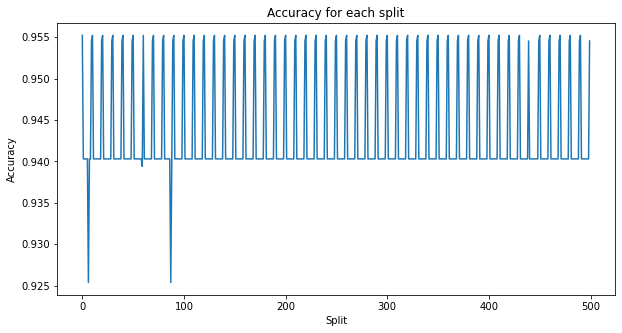

In [56]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_encoded is your DataFrame
X = df_encoded.drop(['default', 'id'], axis=1)  # Features, drop 'id'
y = df_encoded['default']  # Target variable

# Create Random Forest Classifier
clf = RandomForestClassifier()

# Create RepeatedStratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)

# Evaluate model using cross-validation
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Plot the accuracy for each split
plt.figure(figsize=(10,5))
plt.plot(n_scores)
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.title('Accuracy for each split')
plt.show()
